# MNIST Project with Real-time Training Visualization / ResNet
> By Jisang Yun

In [3]:
# Cell 1: Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

# Enable inline plotting
%matplotlib inline

In [4]:
# Cell 2: Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
# Cell 3: Data preprocessing
transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)

print(f'Train Size: {len(train_dataset)}, Test Size: {len(test_dataset)}')

Train Size: 60000, Test Size: 10000


In [6]:
# Cell 4: Data loaders
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Input Size: torch.Size([64, 1, 28, 28])


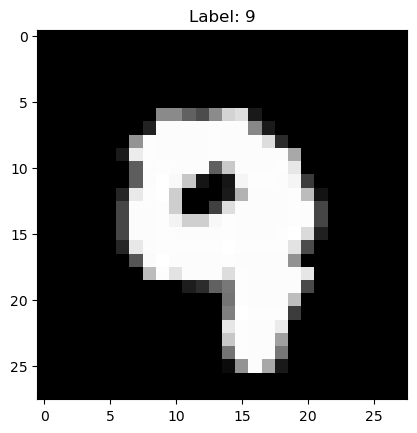

In [7]:
# Cell 5: Show sample image
for example_data, example_labels in train_loader:
    example_image = example_data[0]
    print("Input Size:", example_data.size())
    
    example_image_numpy = example_image.permute(1, 2, 0).numpy()
    plt.imshow(example_image_numpy.squeeze(), cmap='gray')
    plt.title(f"Label: {example_labels[0]}")
    plt.show()
    break

In [8]:
# Cell 6: Define ResidualBlock
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out


In [9]:
# Cell 7: Define SimpleCNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.res_block1 = ResidualBlock(1, 32)
        self.res_block2 = ResidualBlock(32, 64)
        self.res_block3 = ResidualBlock(64, 128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.fc_input_size = self._get_conv_output_size()
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 20)
        self.fc3 = nn.Linear(20, 10)

    def _get_conv_output_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)
            x = self.pool(self.res_block1(x))
            x = self.pool(self.res_block2(x))
            x = self.pool(self.res_block3(x))
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.pool(self.res_block1(x))
        x = self.pool(self.res_block2(x))
        x = self.pool(self.res_block3(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
# Cell 8: Initialize model, loss, optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

Model created with 448,646 parameters


In [11]:
# Cell 9: Real-time visualization function
def plot_training_progress(train_losses, epoch_losses, current_epoch, total_epochs):
    clear_output(wait=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    if train_losses:
        ax1.plot(train_losses, alpha=0.7, linewidth=0.8, color='blue')
        ax1.set_title(f'Training Loss per Batch (Epoch {current_epoch}/{total_epochs})')
        ax1.set_xlabel('Batch Number')
        ax1.set_ylabel('Loss')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, max(1.0, max(train_losses) if train_losses else 1.0))
    
    if epoch_losses:
        epochs_range = range(1, len(epoch_losses) + 1)
        ax2.plot(epochs_range, epoch_losses, 'r-', linewidth=2, marker='o', markersize=4)
        ax2.set_title('Average Training Loss per Epoch')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Average Loss')
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(0, total_epochs)
        if epoch_losses:
            ax2.set_ylim(0, max(epoch_losses) * 1.1)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    if train_losses:
        print(f"Current Batch Loss: {train_losses[-1]:.4f}")
    if epoch_losses:
        print(f"Last Epoch Average Loss: {epoch_losses[-1]:.4f}")
        print(f"Best Epoch Loss: {min(epoch_losses):.4f}")


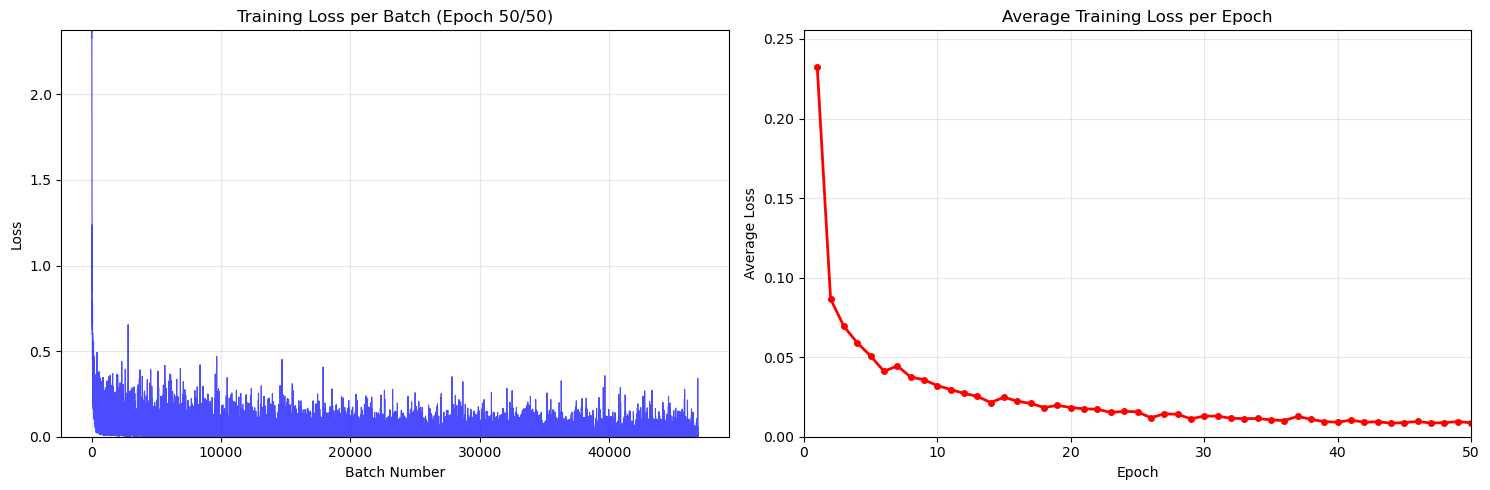

Current Batch Loss: 0.0001
Last Epoch Average Loss: 0.0088
Best Epoch Loss: 0.0085
Epoch 50 completed. Average Loss: 0.0088
Training Finished!


In [12]:
# Cell 10: Training loop
num_epochs = 50 
train_losses = []
epoch_losses = []
running_loss = 0.0
plot_interval = 50

print("Starting Training...")

for epoch in range(num_epochs):
    epoch_loss = 0.0
    batch_count = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        train_losses.append(current_loss)
        epoch_loss += current_loss
        batch_count += 1
        running_loss += current_loss
        
        if i % 100 == 99:
            avg_loss = running_loss / 100
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}")
            running_loss = 0.0
        
        # Update plot every 50 batches
        if i % plot_interval == 0:
            plot_training_progress(train_losses, epoch_losses, epoch + 1, num_epochs)
    
    # End of epoch
    avg_epoch_loss = epoch_loss / batch_count if batch_count > 0 else 0
    epoch_losses.append(avg_epoch_loss)
    plot_training_progress(train_losses, epoch_losses, epoch + 1, num_epochs)
    
    print(f"Epoch {epoch + 1} completed. Average Loss: {avg_epoch_loss:.4f}")

print('Training Finished!')


In [ ]:
# Cell 11: Final training visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, alpha=0.7, linewidth=0.8, color='blue')
plt.title('Final Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), epoch_losses, 'r-', linewidth=2, marker='o', markersize=3)
plt.title('Final Average Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Initial Loss: {train_losses[0]:.4f}")
print(f"Final Loss: {train_losses[-1]:.4f}")
print(f"Best Epoch Loss: {min(epoch_losses):.4f}")
print(f"Loss Reduction: {train_losses[0] - train_losses[-1]:.4f}")

In [ ]:
# Cell 12: Model evaluation
def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_targets)

print("Evaluating model...")
predictions, true_labels = evaluate_model(model, test_loader, device)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision_macro = precision_score(true_labels, predictions, average='macro')
recall_macro = recall_score(true_labels, predictions, average='macro')
f1_macro = f1_score(true_labels, predictions, average='macro')

print("Overall Performance Metrics:")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")

In [ ]:
# Cell 13: Confusion Matrix
mnist_classes = [str(i) for i in range(10)]
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=mnist_classes,
            yticklabels=mnist_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# Cell 14: Per-class performance
precision_per_class = precision_score(true_labels, predictions, average=None)
recall_per_class = recall_score(true_labels, predictions, average=None)
f1_per_class = f1_score(true_labels, predictions, average=None)

x = np.arange(len(mnist_classes))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, precision_per_class, width, label='Precision', alpha=0.8)
plt.bar(x, recall_per_class, width, label='Recall', alpha=0.8)
plt.bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.8)

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Per-Class Performance Metrics')
plt.xticks(x, mnist_classes)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

In [ ]:
# Cell 15: Classification report
print("Detailed Classification Report:")
report = classification_report(true_labels, predictions, target_names=mnist_classes)
print(report)

In [ ]:
# Cell 16: Save submission
print("Generating submission...")
submission_predictions = []

model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        submission_predictions.extend(predicted.cpu().tolist())

submission = pd.DataFrame({
    "ImageId": range(1, len(submission_predictions) + 1),
    "Label": submission_predictions
})

submission.to_csv('submission.csv', index=False)
print(f"Submission saved! Predictions: {len(submission_predictions)}")
print(f"Final Test Accuracy: {accuracy*100:.2f}%")